/Users/choderaj/miniconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


([<matplotlib.axis.XTick at 0x10bac52b0>,
 <a list of 3 Text xticklabel objects>)

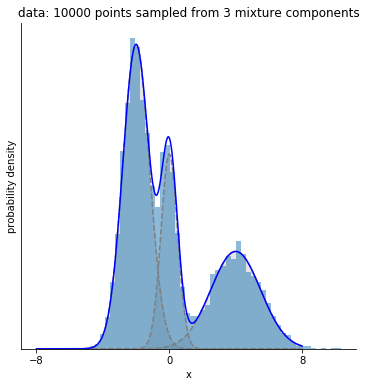

In [1]:
# RJMC for GMMs:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from autograd import numpy as np
np.random.seed(0)
from scipy.stats import norm
from scipy.stats import dirichlet
from scipy.special import logsumexp

def gaussian_mixture_log_likelihood(X, means, stdevs, weights):
    component_log_pdfs = np.array([norm.logpdf(X, loc=mean, scale=stdev) + np.log(weight) for ((mean, stdev), weight) in zip(zip(means, stdevs), weights)])
    return np.sum(logsumexp(component_log_pdfs, 0))

from scipy.stats import norm, invgamma
from scipy.special import logsumexp

def unpack(theta):
    assert(len(theta) % 3 == 0)
    n = int(len(theta) / 3)
    means, stdevs, weights = np.array(theta[:n]), np.array(theta[n:2*n]), np.array(theta[2*n:])
    return means, stdevs, weights

def log_prior(theta):
    means, stdevs, weights = unpack(theta)
    log_prior_on_means = np.sum(norm.logpdf(means, scale=20))
    log_prior_on_variances = np.sum(invgamma.logpdf((stdevs**2), 1.0))
    #log_prior_on_weights = dirichlet.logpdf(weights, np.ones(len(weights)))
    #log_prior_on_weights = np.sum(np.log(weights))
    log_prior_on_weights = 0 # removing the prior on weights to see if this is the culprit...
    return log_prior_on_means + log_prior_on_variances + log_prior_on_weights

def flat_log_p(theta):
    means, stdevs, weights = unpack(theta)
    if np.min(stdevs) <= 0.001: return - np.inf
    log_likelihood = gaussian_mixture_log_likelihood(X=data, means=means,
                                           stdevs=stdevs,
                                           weights=weights)
    
    return log_likelihood + log_prior(theta)

#n_components = 10
#true_means = np.random.rand(n_components) * 10 - 5
#true_stdevs = np.random.rand(n_components) * 0.2
#true_weights = np.random.rand(n_components)**2
#true_weights /= np.sum(true_weights)

n_data = 10000
data = np.zeros(n_data)
#for i in range(n_data):
#    component = np.random.choice(np.arange(n_components), p=true_weights)
#    #component = np.random.randint(n_components)
#    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])

#n_components = 10
#true_means = np.linspace(-5,5,n_components)
#true_stdevs = np.random.rand(n_components)*0.5
#true_weights = np.random.rand(n_components)
#true_weights /= np.sum(true_weights)
#n_data = 300
#data = np.zeros(n_data)
#for i in range(n_data):
#    component = np.random.randint(n_components)
#    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])
    
    
    
n_components = 3
true_means = [-5.0,0.0,5.0]
true_stdevs = np.ones(n_components)
true_weights = np.ones(n_components) / 3

true_means = [-2.0,0.0,4.0]
true_stdevs = [0.8, 0.5, 1.5] 
true_weights = [0.5, 0.2, 0.3]


n_data = 10000
data = np.zeros(n_data)
for i in range(n_data):
    component = np.random.choice(range(n_components), p=true_weights)
    data[i] = norm.rvs(loc=true_means[component], scale=true_stdevs[component])


plt.figure(figsize=(6,6))

ax = plt.subplot(111)
    
plt.hist(data, bins=50, normed=True, alpha=0.5);
x = np.linspace(-8,8, 1000)
y_tot = np.zeros(x.shape)
for i in range(n_components):    
    y = norm.pdf(x, loc=true_means[i], scale=true_stdevs[i]) * true_weights[i]
    plt.plot(x, y, '--', color='grey',)
    plt.fill_between(x, y, color='grey' ,alpha=0.2)
    y_tot += y
plt.plot(x,y_tot, color='blue',)
plt.yticks([])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.title("data: {} points sampled from {} mixture components".format(n_data, n_components))
plt.ylabel('probability density')
plt.xlabel('x')
plt.xticks([-8,0,8])

In [2]:
np.mean(data), np.std(data)

(0.2137570849736155, 2.8201532444671105)

In [18]:
max_components = 50
mean_perturbation_scale = 5.0
stdev_perturbation_scale = 2.0

def reversible_birth_death_move(theta, parents):
    
    means, stdevs, weights = unpack(theta)
    means, stdevs, weights = map(np.array, (means, stdevs, weights))
    
    sum_weights_before = np.sum(weights)
    n_components = len(means)
    
    # decide whether to create a new component
    if n_components == 1:
        birth_probability = 1.0
        log_prob_forward_over_reverse = np.log(1.0 / 0.5) # F: 100% chance of "birth" move, R: 50% chance
    elif n_components == max_components:
        birth_probability = 0.0
        log_prob_forward_over_reverse = np.log(1.0 / 0.5) # F: 100% chance of "death" move, R: 50% chance
    else:
        birth_probability = 0.5
        log_prob_forward_over_reverse = np.log(1.0 / 1.0) # 0
    death_probability = 1.0 - birth_probability
    
    if np.random.rand() < birth_probability:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_birth_move(means, stdevs, weights, parents)
    else:
        (means, stdevs, weights, parents_prime), log_jac_u_term = reversible_death_move(means, stdevs, weights, parents)
    assert(len(means) == len(stdevs))
    theta_prime = np.array(means + stdevs + weights)
    
    sum_weights_after = np.sum(weights)
    assert(np.isclose(sum_weights_before, sum_weights_after))
    return theta_prime, parents_prime, log_jac_u_term - log_prob_forward_over_reverse
    
from scipy.stats import uniform, norm
u_1_distribution = uniform(0, 1)
u_2_distribution = norm(0, 1)
u_3_distribution = norm(0, 1)


def reversible_birth_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(len(means)) # choose a parent component at random
    u_1 = u_1_distribution.rvs()
    u_2 = u_2_distribution.rvs()
    u_3 = u_3_distribution.rvs()
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / len(means)) + u_1_distribution.logpdf(u_1) + u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # compute the parameters of the new mixture component
    weight_new = weights[i] * u_1
    mean_new = (u_2 * mean_perturbation_scale) + means[i]
    stdev_new = (u_3 * stdev_perturbation_scale) + stdevs[i]
    
    # compute log determinant of the jacobian
    log_jacobian_determinant = np.log(weights[i]) + np.log(mean_perturbation_scale) + np.log(stdev_perturbation_scale)
    
    # subtract the new mixture component's weight from its parent
    weights[i] -= weight_new
    
    # update means, stdevs, weights, parents
    means.append(mean_new)
    stdevs.append(stdev_new)
    weights.append(weight_new)
    parents.append(i)
    
    return (means, stdevs, weights, parents), (log_jacobian_determinant - log_prob_u)

def mmc_move(theta, parents):
    """Standard Metropolis Monte Carlo move.
    
    (Contributed by JDC)
    """            
    theta_prime = np.array(theta)
    parents_prime = list(parents)
            
    n = int(len(theta) / 3)
            
    SIGMA_MEAN = 0.05
    SIGMA_STDDEV = 0.05
    SIGMA_WEIGHT = 0.05
    
    # different proposal sizes for mean, stdev, weight
    i = np.random.randint(n)
    j = np.random.randint(n)
    delta_mean = SIGMA_MEAN * np.random.randn()
    delta_stddev = SIGMA_STDDEV * np.random.randn()
    delta_weight = SIGMA_WEIGHT * np.random.randn()
    
    theta_prime[i] += delta_mean
    theta_prime[n+i] += delta_stddev
    theta_prime[2*n+i] += delta_weight
    theta_prime[2*n+j] -= delta_weight
            
    log_jac_u_term = 0.0
    if np.any(theta_prime[n:2*n] <= 0.0) or np.any(theta_prime[2*n:] <= 0.0) or not np.isclose(np.sum(theta_prime[2*n:]), 1.0):
        # Force reject
        #print(theta_prime)
        log_jac_u_term = - np.inf
            
    return theta_prime, parents_prime, log_jac_u_term
    
def reversible_death_move(means, stdevs, weights, parents):
    # make local copies to be extra sure we're not accidentally overwriting...
    means, stdevs, weights, parents = map(list, (means, stdevs, weights, parents))
    
    # draw all the random numbers we're going to use
    i = np.random.randint(1, len(means)) # choose a component at random to remove, except component 0
    
    # compute the log probability density of all the random numbers we drew
    log_prob_u = np.log(1.0 / (len(means) - 1))
    
    # and also the log probability density of the random numbers we would have drawn?
    weight_new = weights[i]
    mean_new = means[i]
    stdev_new = stdevs[i]
    u_1 = weight_new / weights[parents[i]]
    u_2 = (mean_new - means[parents[i]] ) / mean_perturbation_scale
    u_3 = (stdev_new - stdevs[parents[i]]) / stdev_perturbation_scale
    log_prob_u += u_1_distribution.logpdf(u_1) + u_2_distribution.logpdf(u_2) + u_3_distribution.logpdf(u_3)
    
    # also I think we need to compute the jacobian determinant of the inverse
    inv_log_jacobian_determinant = np.log(weights[parents[i]]) + np.log(mean_perturbation_scale) + np.log(stdev_perturbation_scale)
    log_jacobian_determinant = - inv_log_jacobian_determinant
    
    # remove this mixture component, and re-allocate its weight to its parent
    weights[parents[i]] += weights[i]
    
    # update the parent list, so that any j whose parent just got deleted is assigned a new parent
    for j in range(1, len(parents)):
        if parents[j] == i:
            parents[j] = parents[i]
            
    # wait, this is almost certainly wrong, because the indices will change...
    _ = means.pop(i)
    _ = stdevs.pop(i)
    _ = weights.pop(i)
    _ = parents.pop(i)
    
    # fix indices
    for j in range(1, len(parents)):
        if parents[j] > i:
            parents[j] -= 1
    
    return (means, stdevs, weights, parents), (log_jacobian_determinant - log_prob_u)

from tqdm import tqdm
def rjmcmc_w_parents(theta, parents, n_steps=10000):
    
    traj = [(theta, parents)]
    old_log_p = flat_log_p(theta)
    acceptance_probabilities = []
    
    for t in tqdm(range(n_steps)):
        # generate proposal
        if np.random.rand() < 0.25:
            theta_prime, parents_prime, log_jac_u_term = reversible_birth_death_move(theta, parents)
        else:
            theta_prime, parents_prime, log_jac_u_term = mmc_move(theta, parents) 
        
        new_log_p = flat_log_p(theta_prime)
        log_prob_ratio = new_log_p - old_log_p
        if not np.isfinite(new_log_p):
            A = 0
            #print(RuntimeWarning("new_log_p isn't finite: theta = {}, parents = {}".format(theta_prime, parents_prime)))
        else:
            A = min(1.0, np.exp(log_prob_ratio + log_jac_u_term))
    
        if np.random.rand() < A:
            theta = theta_prime
            parents = parents_prime
            old_log_p = new_log_p
            
            if len(theta) != len(traj[-1][0]):
                prev_dim = int(len(traj[-1][0]) / 3)
                current_dim = int(len(theta) / 3)
                assert(len(theta) % 3 == 0)

                #print('{}: accepted a cross-model jump! # components: {} --> {}'.format(t, prev_dim, current_dim))
        traj.append((theta, parents))
        acceptance_probabilities.append(A)
    return traj, acceptance_probabilities

In [19]:
np.random.seed(0)
init_n_components = 1
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None] + list(range(init_n_components - 1))
traj, acceptance_probabilities = rjmcmc_w_parents(init_theta, init_parents, n_steps=100000)

  0%|          | 52/100000 [00:00<03:14, 514.38it/s]/Users/choderaj/miniconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
100%|██████████| 100000/100000 [03:08<00:00, 531.86it/s]


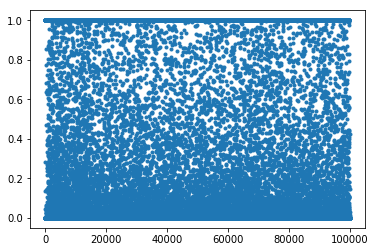

In [20]:
plt.plot([a for a in acceptance_probabilities], '.')

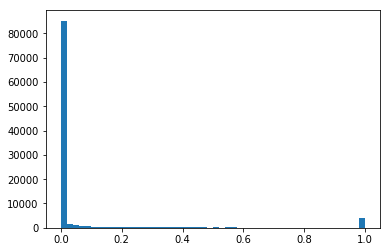

In [21]:
plt.hist(acceptance_probabilities, bins=50);

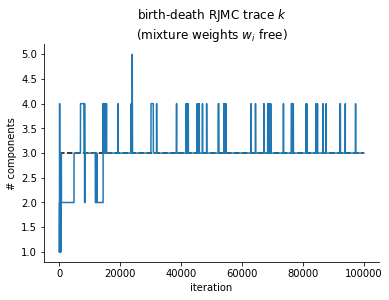

In [22]:
n_components_traj = np.array([len(t[0]) / 3 for t in traj], np.int32)
ax = plt.subplot(111)
plt.plot(n_components_traj)
plt.hlines(n_components, 0, len(traj), linestyles='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('# components')
plt.xlabel('iteration')
plt.title(r'birth-death RJMC trace $k$' + '\n(mixture weights ' + r'$w_i$ free)')
#plt.xscale('log')
plt.savefig('birth-death-n-components-starting-from-1.jpg', dpi=300)

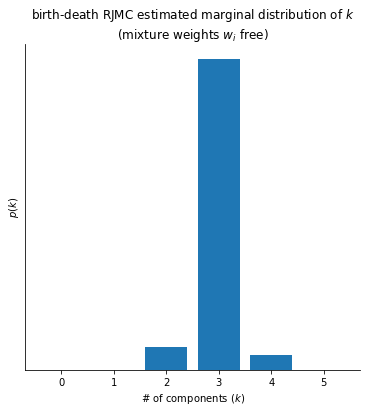

In [23]:
plt.figure(figsize=(6,6))

burned_in = n_components_traj[1000:]

counts = np.bincount(burned_in)
n_components_range = list(range(len(counts)))

ax = plt.subplot(111)

plt.bar(n_components_range, counts / sum(counts))
plt.xlabel(r'# of components ($k$)')
plt.ylabel(r'$p(k)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'birth-death RJMC estimated marginal distribution of $k$' + '\n(mixture weights ' + r'$w_i$ free)')
plt.xticks(n_components_range)
plt.yticks([])
plt.savefig('birth-death-marginals-starting-from-1.jpg', dpi=300)

In [24]:
change_points = list(np.arange(1, len(n_components_traj))[np.diff(n_components_traj) != 0])
trajs = []
for (start, end) in list(zip([0] + change_points, change_points + [len(traj)])):
    trajs.append(np.array([t[0] for t in traj[start:end]]))

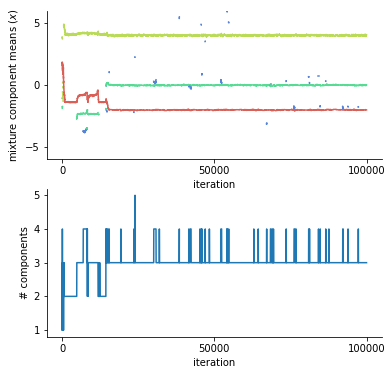

In [25]:
plt.figure(figsize=(6,6))
ax = plt.subplot(2, 1, 1)
colors = sns.color_palette("hls", n_components_traj.max())
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 3)
    #plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components], color='blue')
    for n in range(n_components):
        plt.plot(np.arange(x_init, x_end), trajs[i][:,n], color=colors[n])
plt.ylim(-6,6)
plt.yticks([-5,0,5])
plt.xticks([0,50000,100000])
plt.xlabel('iteration')
plt.ylabel(r'mixture component means ($x$)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = plt.subplot(2, 1, 2, sharex=ax)
plt.plot(n_components_traj)
plt.xlabel('iteration')
plt.ylabel(r'# components')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('birth-death-branching-1.jpg', dpi=600, bbox_inches='tight')

In [26]:
np.random.seed(1)
init_n_components = 50
init_means = np.random.randn(init_n_components)
init_stdevs = np.random.rand(init_n_components) + 1
init_weights = np.random.rand(init_n_components)
init_weights /= np.sum(init_weights)
init_theta = np.hstack([init_means, init_stdevs, init_weights])
init_parents = [None] + list(range(init_n_components - 1))
traj, acceptance_probabilities = rjmcmc_w_parents(init_theta, init_parents, n_steps=100000)

  0%|          | 0/100000 [00:00<?, ?it/s]/Users/choderaj/miniconda/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
100%|██████████| 100000/100000 [03:11<00:00, 522.18it/s]


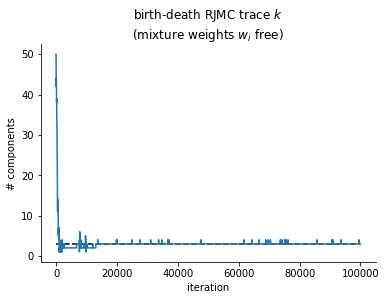

In [31]:
n_components_traj = np.array([len(t[0]) / 3 for t in traj], np.int32)
ax = plt.subplot(111)
plt.plot(n_components_traj)
plt.hlines(n_components, 0, len(traj), linestyles='--')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('# components')
plt.xlabel('iteration')
plt.title(r'birth-death RJMC trace $k$' + '\n(mixture weights ' + r'$w_i$ free)')
#plt.xscale('log')
plt.savefig('birth-death-n-components-starting-from-50.jpg', dpi=300)

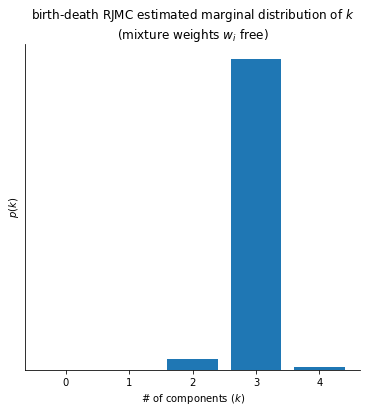

In [32]:
plt.figure(figsize=(6,6))

burned_in = n_components_traj[10000:]

counts = np.bincount(burned_in)
n_components_range = list(range(len(counts)))

ax = plt.subplot(111)

plt.bar(n_components_range, counts / sum(counts))
plt.xlabel(r'# of components ($k$)')
plt.ylabel(r'$p(k)$')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title(r'birth-death RJMC estimated marginal distribution of $k$' + '\n(mixture weights ' + r'$w_i$ free)')
plt.xticks(n_components_range)
plt.yticks([])
plt.savefig('birth-death-marginals-starting-from-50.jpg', dpi=300)

In [33]:
change_points = list(np.arange(1, len(n_components_traj))[np.diff(n_components_traj) != 0])
trajs = []
for (start, end) in list(zip([0] + change_points, change_points + [len(traj)])):
    trajs.append(np.array([t[0] for t in traj[start:end]]))

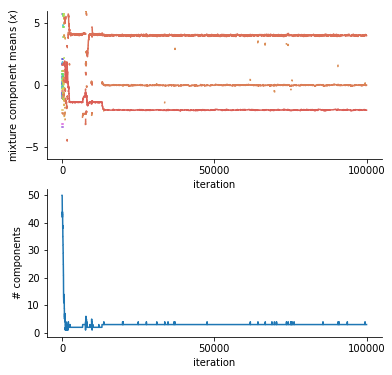

In [34]:
plt.figure(figsize=(6,6))
ax = plt.subplot(2, 1, 1)
colors = sns.color_palette("hls", n_components_traj.max())
for i in range(len(trajs)):
    x_init = sum([len(t) for t in trajs[:i]])
    x_end = x_init + len(trajs[i])
    n_components = int(trajs[i].shape[1] / 3)
    #plt.plot(np.arange(x_init, x_end), trajs[i][:,:n_components], color='blue')
    for n in range(n_components):
        plt.plot(np.arange(x_init, x_end), trajs[i][:,n], color=colors[n])
plt.ylim(-6,6)
plt.yticks([-5,0,5])
plt.xticks([0,50000,100000])
plt.xlabel('iteration')
plt.ylabel(r'mixture component means ($x$)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax = plt.subplot(2, 1, 2, sharex=ax)
plt.plot(n_components_traj)
plt.xlabel('iteration')
plt.ylabel(r'# components')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('birth-death-branching-50.jpg', dpi=600, bbox_inches='tight')

In [35]:
trees = [t[-1] for t in traj[1000:]]

In [36]:
for _ in range(20):
    print(trees[np.random.randint(len(trees))])

[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]
[None, 0, 1]


In [37]:
import networkx as nx

In [38]:
def parent_list_to_graph(parent_list):
    
    graph = nx.DiGraph()
    
    for i in range(1, len(parent_list)):
        graph.add_edge(parent_list[i], i)
    return graph

In [39]:
g = parent_list_to_graph(trees[-1])
g.nodes()

NodeView((0, 1, 2))

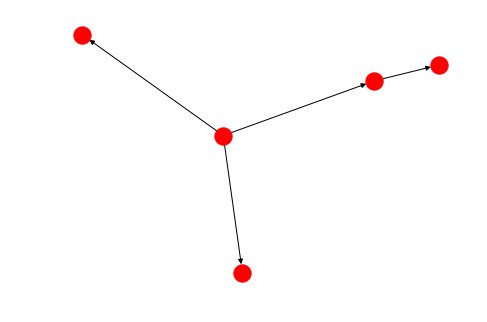

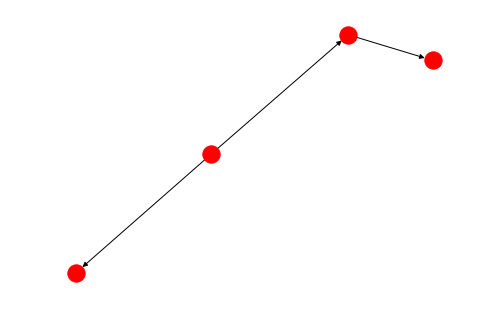

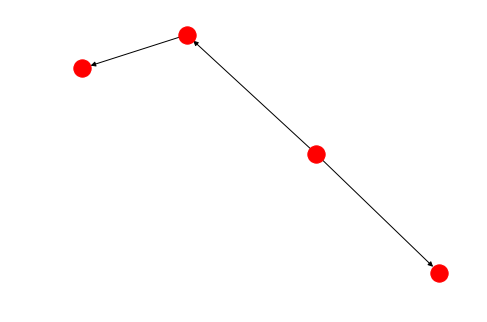

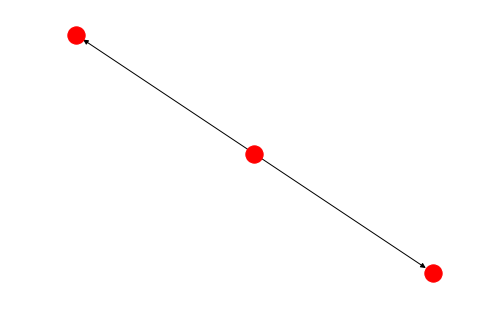

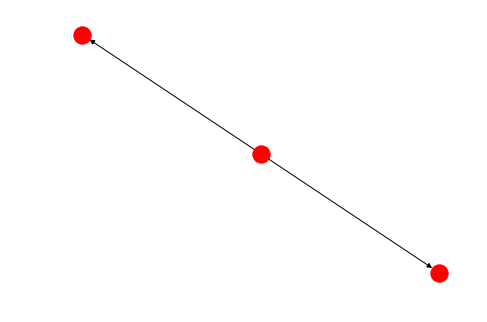

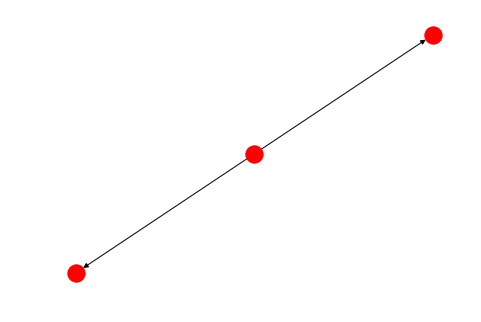

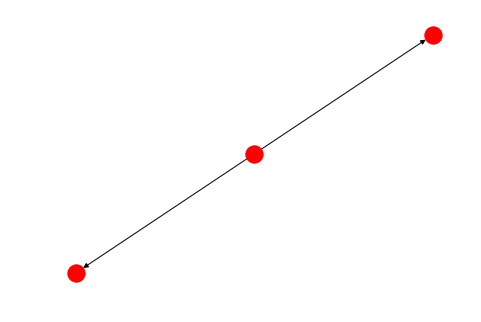

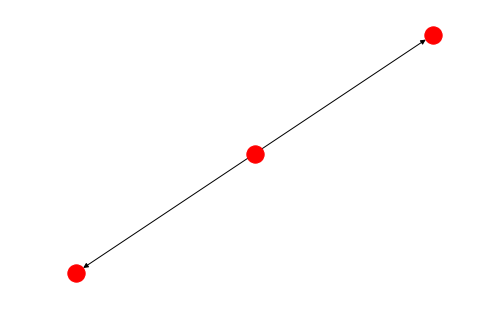

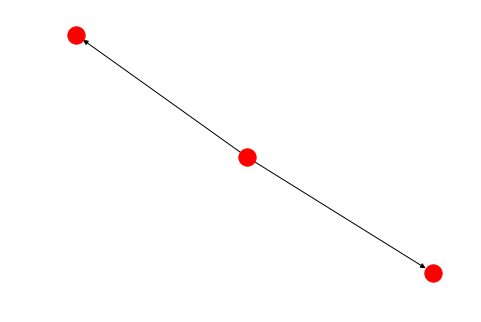

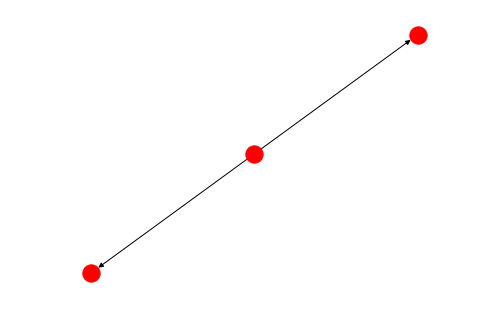

In [40]:
for t in trees[:10]:
    g = parent_list_to_graph(t)
    plt.figure()
    nx.draw(g, pos=nx.drawing.spring_layout(g))

In [ ]:
log_posterior = np.array([flat_log_p(t[0]) for t in traj])
log_prior = np.array([log_prior(t[0]) for t in traj])
log_likelihood = log_posterior - log_prior

In [ ]:
plt.plot(log_prior, label='prior')
plt.plot(log_likelihood, label='likelihood')
plt.plot(log_posterior, label='posterior')
plt.legend(loc='best')
plt.ylabel('log probability')
plt.xlabel('iteration')
plt.xscale('log')

plt.savefig('birth-death-log-posterior.jpg', dpi=300)